In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Setting to make numbers easier to read on display
pd.set_option('display.float_format', '{:.2f}'.format)

# Show all columns on output
pd.set_option('display.max_columns', 999)

## Data Exploration

In [5]:
# Reading the first sheet from the excel file 
df = pd.read_excel("./data/online_retail_II.xlsx", sheet_name = 0)

df.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.00,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom


In [70]:
# Getting a high level view of our dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


***Note 1:***
 1. Customer ID is lacking some information as it only has 406830 rows while the dataset consists of 541910 entries.

2.  The invoiceDate has already been given into ns, so no conversion needed. 

In [ ]:
# More statistical details related to numeric values
df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,525461.00,525461,525461.00,417534.00
mean,10.34,2010-06-28 11:37:36.845017856,4.69,15360.65
min,-9600.00,2009-12-01 07:45:00,-53594.36,12346.00
25%,1.00,2010-03-21 12:20:00,1.25,13983.00
50%,3.00,2010-07-06 09:51:00,2.10,15311.00
75%,10.00,2010-10-15 12:45:00,4.21,16799.00
max,19152.00,2010-12-09 20:01:00,25111.09,18287.00
std,107.42,NaN,146.13,1680.81


***Note 2:***
1. Quantity and price have a negative minimum value which is abnormal and needs to be fixed.
2. The customerID column presents less null values than the other columns.

In [ ]:
# Getting information about objects or string like data 
df.describe(include='O')

,Invoice,StockCode,Description,Country
count,525461,525461,522533,525461
unique,28816,4632,4681,40
top,537434,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
freq,675,3516,3549,485852


***Note 3:***
Invoice is considered as a string while it contains numeric data. 

In [ ]:
# Taking a look at null 'Customer ID' data

''' Selecting data from df such as it is related to a NaN value of CustomerID '''
df[df["Customer ID"].isna()].head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
263,489464,21733,85123a mixed,-96,2009-12-01 10:52:00,0.00,NaN,United Kingdom
283,489463,71477,short,-240,2009-12-01 10:52:00,0.00,NaN,United Kingdom
284,489467,85123A,21733 mixed,-192,2009-12-01 10:53:00,0.00,NaN,United Kingdom
470,489521,21646,NaN,-50,2009-12-01 11:44:00,0.00,NaN,United Kingdom
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.55,NaN,United Kingdom
578,489525,85227,SET/6 3D KIT CARDS FOR KIDS,1,2009-12-01 11:49:00,0.85,NaN,United Kingdom
1055,489548,22271,FELTCRAFT DOLL ROSIE,1,2009-12-01 12:32:00,2.95,NaN,United Kingdom
1056,489548,22254,FELT TOADSTOOL LARGE,12,2009-12-01 12:32:00,1.25,NaN,United Kingdom
1057,489548,22273,FELTCRAFT DOLL MOLLY,3,2009-12-01 12:32:00,2.95,NaN,United Kingdom
1058,489548,22195,LARGE HEART MEASURING SPOONS,1,2009-12-01 12:32:00,1.65,NaN,United Kingdom


When the Customer ID is missing, we cannot actively work on that data or categorize it. 

**Strategy when cleaning the data** : 
Dropping the NaN Customer ID rows. 

In [ ]:
# What about the negative quantities noticed?
df[df["Quantity"] <0].head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.00,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.00,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.00,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.00,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.00,Australia
183,C489449,21871,SAVE THE PLANET MUG,-12,2009-12-01 10:33:00,1.25,16321.00,Australia
184,C489449,84946,ANTIQUE SILVER TEA GLASS ETCHED,-12,2009-12-01 10:33:00,1.25,16321.00,Australia
185,C489449,84970S,HANGING HEART ZINC T-LIGHT HOLDER,-24,2009-12-01 10:33:00,0.85,16321.00,Australia
186,C489449,22090,PAPER BUNTING RETRO SPOTS,-12,2009-12-01 10:33:00,2.95,16321.00,Australia
196,C489459,90200A,PURPLE SWEETHEART BRACELET,-3,2009-12-01 10:44:00,4.25,17592.00,United Kingdom


***Note:***  C in the Invoice indicates it is a cancellation.

In [ ]:
#  all the Invoice numbers are made of 6 digets and start with C or no letter
df["Invoice"] = df["Invoice"].astype("str")
df[df["Invoice"].str.match("^\\d{6}$") == True]   # exactly 6 digets

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.00,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.00,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.00,United Kingdom


In [ ]:
# Is C the only caracter that appears in the Invoide numbers?

# Replacing all the degits in the invoice numbers by an empty spave to get those that start with C 
df["Invoice"].str.replace("[0-9]","",regex = True).unique()


array(['', 'C', 'A'], dtype=object)

In [ ]:
# Checking for the Invoice strings that start with A 
df[df["Invoice"].str.startswith("A")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
179403,A506401,B,Adjust bad debt,1,2010-04-29 13:36:00,-53594.36,NaN,United Kingdom
276274,A516228,B,Adjust bad debt,1,2010-07-19 11:24:00,-44031.79,NaN,United Kingdom
403472,A528059,B,Adjust bad debt,1,2010-10-20 12:04:00,-38925.87,NaN,United Kingdom


**Strategy when data cleaning:** Removing this subset of the data.

In [ ]:
# StockCode, based on the dataset information is a 5 digit number ... let's check it out !
df["StockCode"] = df["StockCode"].astype("str")

# Records that disobey the pattern "^\\d{5}$" of 5 digits only followed by repeating letters 
df[(df["StockCode"].str.match("^\\d{5}$") == False) & (df["StockCode"].str.match("^\\d{5}[a-zA-Z]+$") == False)]["StockCode"].unique()

#This statement allows us to know which unique stockcodes do not follow the preset regex pattern 

array(['POST', 'D', 'DCGS0058', 'DCGS0068', 'DOT', 'M', 'DCGS0004',
       'DCGS0076', 'C2', 'BANK CHARGES', 'DCGS0003', 'TEST001',
       'gift_0001_80', 'DCGS0072', 'gift_0001_20', 'DCGS0044', 'TEST002',
       'gift_0001_10', 'gift_0001_50', 'DCGS0066N', 'gift_0001_30',
       'PADS', 'ADJUST', 'gift_0001_40', 'gift_0001_60', 'gift_0001_70',
       'gift_0001_90', 'DCGSSGIRL', 'DCGS0006', 'DCGS0016', 'DCGS0027',
       'DCGS0036', 'DCGS0039', 'DCGS0060', 'DCGS0056', 'DCGS0059', 'GIFT',
       'DCGSLBOY', 'm', 'DCGS0053', 'DCGS0062', 'DCGS0037', 'DCGSSBOY',
       'DCGSLGIRL', 'S', 'DCGS0069', 'DCGS0070', 'DCGS0075', 'B',
       'DCGS0041', 'ADJUST2', '47503J ', 'C3', 'SP1002', 'AMAZONFEE'],
      dtype=object)

In [ ]:
df[df["StockCode"].str.contains("^DOT")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
2379,489597,DOT,DOTCOM POSTAGE,1,2009-12-01 14:28:00,647.19,NaN,United Kingdom
2539,489600,DOT,DOTCOM POSTAGE,1,2009-12-01 14:43:00,55.96,NaN,United Kingdom
2551,489601,DOT,DOTCOM POSTAGE,1,2009-12-01 14:44:00,68.39,NaN,United Kingdom
2571,489602,DOT,DOTCOM POSTAGE,1,2009-12-01 14:45:00,59.35,NaN,United Kingdom
2619,489603,DOT,DOTCOM POSTAGE,1,2009-12-01 14:46:00,42.39,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
524272,538071,DOT,DOTCOM POSTAGE,1,2010-12-09 14:09:00,885.94,NaN,United Kingdom
524887,538148,DOT,DOTCOM POSTAGE,1,2010-12-09 16:26:00,547.32,NaN,United Kingdom
525000,538149,DOT,DOTCOM POSTAGE,1,2010-12-09 16:27:00,620.68,NaN,United Kingdom
525126,538153,DOT,DOTCOM POSTAGE,1,2010-12-09 16:31:00,822.94,NaN,United Kingdom


In [ ]:
# Import the pandas library, which is used for data manipulation and analysis.
import pandas as pd

# Define the data as a dictionary. Each key in the dictionary represents a column in the table.
# The values for each key are lists containing the data for that column.
data = {
    "Code": ["DCGS", "D", "DOT", "M or m", "C2", "C3", "BANK CHARGES or B", "S", "TESTXXX", "gift__XXX", "PADS", "SP1002", "AMAZONFEE", "ADJUSTX"],
    "Description": [
        "Looks valid, some quantities are negative though and customer ID is null",
        "Looks valid, represents discount values",
        "Looks valid, represents postage charges",
        "Looks valid, represents manual transactions",
        "Carriage transaction - not sure what this means",
        "Not sure, only 1 transaction",
        "Bank charges",
        "Samples sent to customer",
        "Testing data, not valid",
        "Purchases with gift cards, might be interesting for another analysis, but no customer data",
        "Looks like a legit stock code for padding",
        "Looks like a special request item, only 2 transactions, 3 look legit, 1 has 0 pricing",
        "Looks like fees for Amazon shipping or something",
        "Looks like manual account adjustments by admins"
    ],
    "Action": [
        "Exclude from clustering",
        "Exclude from clustering",
        "Exclude from clustering",
        "Exclude from clustering",
        "Exclude from clustering",
        "Exclude",
        "Exclude from clustering",
        "Exclude from clustering",
        "Exclude from clustering",
        "Exclude",
        "Include",
        "Exclude for now",
        "Exclude for now",
        "Exclude for now"
    ]
}

# Create a pandas DataFrame from the dictionary.
# A DataFrame is a 2-dimensional labeled data structure with columns of potentially different types.
table = pd.DataFrame(data)

# Display the DataFrame in the notebook.
# When you run this cell, the table will be rendered in a clean, readable format.
table

,Code,Description,Action
0,DCGS,"Looks valid, some quantities are negative thou...",Exclude from clustering
1,D,"Looks valid, represents discount values",Exclude from clustering
2,DOT,"Looks valid, represents postage charges",Exclude from clustering
3,M or m,"Looks valid, represents manual transactions",Exclude from clustering
4,C2,Carriage transaction - not sure what this means,Exclude from clustering
5,C3,"Not sure, only 1 transaction",Exclude
6,BANK CHARGES or B,Bank charges,Exclude from clustering
7,S,Samples sent to customer,Exclude from clustering
8,TESTXXX,"Testing data, not valid",Exclude from clustering
9,gift__XXX,"Purchases with gift cards, might be interestin...",Exclude


## Data Cleaning

In [6]:
cleaned_df = df.copy()

In [7]:
# Converting the Invoice values into strings so that we can use regex expressions on them
cleaned_df["Invoice"] = cleaned_df["Invoice"].astype("str")

# Filtering expression: keeping the invoice codes that consists of 6 digets only
mask =  (
    cleaned_df["Invoice"].str.match("^\\d{6}$") == True
)

cleaned_df = cleaned_df[mask]

cleaned_df


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.00,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.00,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.00,United Kingdom


In [8]:
# Cleaning StockCodes and keeping legitimate
cleaned_df["StockCode"] = cleaned_df["StockCode"].astype("str")

mask = (
    cleaned_df["StockCode"].str.match("^\\d{5}$") == True
    | (cleaned_df["StockCode"].str.match("^\\d{5}[a-zA-Z]+$") == True)
    | (cleaned_df["StockCode"].str.match("^PADS$") == True)
)

clean_df = cleaned_df[mask]
cleaned_df


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.00,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.00,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.00,United Kingdom


In [9]:
# Removing null custumers : dropping NaN values of customer ID
clean_df.dropna(subset = ["Customer ID"], inplace = True)

C:\Users\hp04\AppData\Local\Temp\ipykernel_348\793709644.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df.dropna(subset = ["Customer ID"], inplace = True)


In [10]:
# Checking if all the negative prices and quantities have been removed 
cleaned_df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,515252.00,515252,515252.00,407695.00
mean,10.96,2010-06-28 17:40:54.093763584,4.22,15368.50
min,-9600.00,2009-12-01 07:45:00,0.00,12346.00
25%,1.00,2010-03-21 13:27:00,1.25,13997.00
50%,3.00,2010-07-06 13:13:00,2.10,15321.00
75%,10.00,2010-10-15 14:27:00,4.21,16812.00
max,19152.00,2010-12-09 20:01:00,25111.09,18287.00
std,104.35,NaN,63.44,1679.80


***Note:***  
 1. Dealing with NaN Customer IDs have automatically dropped the problematic negative quantity value.
2. There are null prices to be dropped. 

In [11]:
len(cleaned_df[cleaned_df["Price"] == 0])

3687

In [12]:
cleaned_df = cleaned_df[cleaned_df["Price"]> 0]
cleaned_df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,511565.00,511565,511565.00,407664.00
mean,11.40,2010-06-28 22:20:55.320946688,4.25,15368.59
min,1.00,2009-12-01 07:45:00,0.00,12346.00
25%,1.00,2010-03-21 15:22:00,1.25,13997.00
50%,3.00,2010-07-07 09:41:00,2.10,15321.00
75%,10.00,2010-10-15 15:06:00,4.21,16812.00
max,19152.00,2010-12-09 20:01:00,25111.09,18287.00
std,86.76,NaN,63.66,1679.76


Here, the minimum price seems to be a very small one, very close to 0.  But all the prices are greater than 0. 

In [13]:
cleaned_df["Price"].min()

np.float64(0.001)

In [14]:
# How much data have we lost during the data cleaning process?
len(cleaned_df)/len(df)

0.9735546501072392

After the data cleaning process, we still have got 97% of our dataset. 
Dropped about 3% of records. 

# Clustering: An Overview

Clustering is an unsupervised machine learning technique used to group similar data points together based on their features. The goal of clustering is to identify patterns or structures in the data without any prior knowledge of the labels or categories.

## How Clustering Works

### 1. **Objective**
   - The main objective of clustering is to partition a dataset into groups (or clusters) such that:
     - Data points within the same cluster are **similar** to each other.
     - Data points from different clusters are **dissimilar**.

### 2. **Key Concepts**
   - **Similarity Measure**: Clustering algorithms use a similarity measure (e.g., Euclidean distance, cosine similarity) to determine how close or similar two data points are.
   - **Cluster Centroids**: In some algorithms (like K-Means), each cluster is represented by a centroid, which is the mean of all the points in the cluster.
   - **Number of Clusters (k)**: Many clustering algorithms require the user to specify the number of clusters (`k`) in advance.

### 3. **Common Clustering Algorithms**
   - **K-Means Clustering**:
     - Divides the dataset into `k` clusters.
     - Iteratively assigns data points to the nearest centroid and updates the centroids.
     - Converges when the centroids no longer change significantly.
   - **Hierarchical Clustering**:
     - Builds a tree-like structure (dendrogram) to represent data points.
     - Can be agglomerative (bottom-up) or divisive (top-down).
   - **DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**:
     - Groups together data points that are closely packed together.
     - Identifies outliers as noise.

### 4. **Steps in Clustering**
   - **Step 1: Choose the Number of Clusters (`k`)**:
     - For algorithms like K-Means, decide how many clusters you want to create.
   - **Step 2: Initialize Centroids**:
     - Randomly select `k` data points as initial centroids.
   - **Step 3: Assign Data Points to Clusters**:
     - Assign each data point to the nearest centroid based on the similarity measure.
   - **Step 4: Update Centroids**:
     - Recalculate the centroids as the mean of all data points in the cluster.
   - **Step 5: Repeat**:
     - Repeat steps 3 and 4 until the centroids no longer change significantly.

### 5. **Evaluation of Clusters**
   - **Silhouette Score**: Measures how similar a data point is to its own cluster compared to other clusters.
   - **Inertia**: In K-Means, it measures the sum of squared distances of data points to their closest centroid. Lower inertia indicates better clustering.
   - **Dendrogram**: Used in hierarchical clustering to visualize the merging process and decide the number of clusters.

### 6. **Applications of Clustering**
   - Customer segmentation in marketing.
   - Image segmentation in computer vision.
   - Anomaly detection in network security.
   - Document clustering in natural language processing.

### 7. **Challenges in Clustering**
   - Choosing the right number of clusters (`k`).
   - Handling high-dimensional data.
   - Dealing with noise and outliers.
   - Scalability for large datasets.

---

**Note**: Clustering is a powerful tool for exploratory data analysis, but it requires careful tuning and interpretation of results.

## Feature Engineering
**Key features focused on:**
1. ***Recency*** : how many days has it been since a client made a purchase.
2. ***Frequency***: how many  total purchaces has a client made in the dataset.
3. ***Monetory value*** : some of total montary contribution of each client.

In [15]:
# Computing a line total : the total amount spent on a particular transaction. Easier to aggregate in a sum moneory value. 
cleaned_df["SalesLineTotal"] = cleaned_df["Quantity"]*cleaned_df["Price"]
cleaned_df

C:\Users\hp04\AppData\Local\Temp\ipykernel_348\1529814214.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df["SalesLineTotal"] = cleaned_df["Quantity"]*cleaned_df["Price"]


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,SalesLineTotal
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom,83.40
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom,81.00
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom,81.00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.00,United Kingdom,100.80
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom,30.00
...,...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.00,United Kingdom,5.90
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom,3.75
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom,3.75
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.00,United Kingdom,7.50


In [16]:
# Grouping by customer ID + Computing the value for recency,frequency and monetory value
aggregated_df = cleaned_df.groupby(by = "Customer ID", as_index=False) \
    .agg(
        MonetoryValue = ("SalesLineTotal","sum"),
        Frequency = ("Invoice","nunique"),
        LastInvoiceDate = ("InvoiceDate","max")
    )
  
# The \ is just a pandas sythax to keep on coding in another line

# .agg is an agregation method: newColumn = ("existingColumn","aggregation fumction (max, min,sum, ...)")   

aggregated_df.head(5)

,Customer ID,MonetoryValue,Frequency,LastInvoiceDate
0,12346.00,372.86,11,2010-06-28 13:53:00
1,12347.00,1323.32,2,2010-12-07 14:57:00
2,12348.00,222.16,1,2010-09-27 14:59:00
3,12349.00,2671.14,3,2010-10-28 08:23:00
4,12351.00,300.93,1,2010-11-29 15:23:00


In [17]:
# Latest time when a purchase occured
max_invoice_date = aggregated_df["LastInvoiceDate"].max()

# Creating the recency column
# The recency will be measured in days : dt is a pandas method for date time
aggregated_df["Recency"] = (max_invoice_date - aggregated_df["LastInvoiceDate"]).dt.days

aggregated_df.head(5)


,Customer ID,MonetoryValue,Frequency,LastInvoiceDate,Recency
0,12346.00,372.86,11,2010-06-28 13:53:00,164
1,12347.00,1323.32,2,2010-12-07 14:57:00,2
2,12348.00,222.16,1,2010-09-27 14:59:00,73
3,12349.00,2671.14,3,2010-10-28 08:23:00,42
4,12351.00,300.93,1,2010-11-29 15:23:00,10


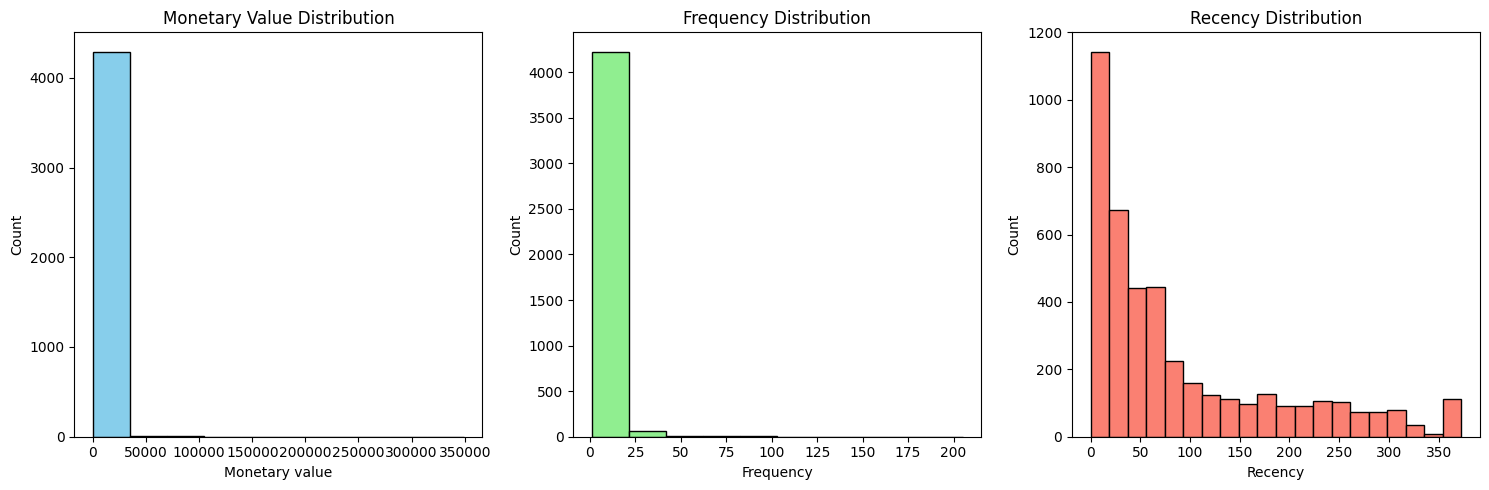

In [18]:
# Features distributions: Plotting their histograms
plt.figure(figsize = (15,5))

# 1 row and 3 columns. 

# Monetary value histogram
plt.subplot(1, 3, 1)
plt.hist(aggregated_df["MonetoryValue"], bins=10, color="skyblue", edgecolor="black")
plt.title("Monetary Value Distribution")
plt.xlabel("Monetary value")
plt.ylabel("Count")

# Frequency histogram
plt.subplot(1, 3, 2)
plt.hist(aggregated_df['Frequency'], bins=10, color='lightgreen', edgecolor='black')
plt.title('Frequency Distribution')
plt.xlabel('Frequency')
plt.ylabel('Count')

# Recency histogram
plt.subplot(1, 3, 3)
plt.hist(aggregated_df['Recency'], bins=20, color='salmon', edgecolor='black')
plt.title('Recency Distribution')
plt.xlabel('Recency')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

**Detecting outliers** : We use boxplots

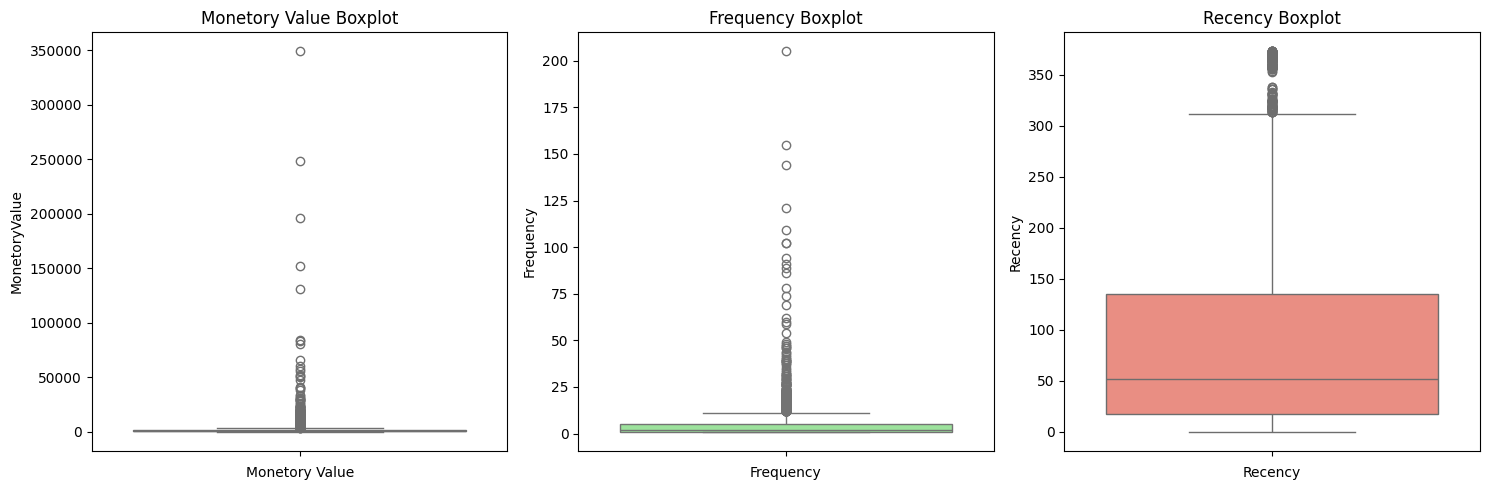

In [20]:
# Outliers detection using boxplots

plt.figure(figsize=(15,5))

# Monetory Value
plt.subplot(1, 3, 1)
sns.boxplot(data=aggregated_df["MonetoryValue"],color="skyblue")
plt.title("Monetory Value Boxplot")
plt.xlabel("Monetory Value")

# Frequency
plt.subplot(1, 3, 2)
sns.boxplot(data=aggregated_df['Frequency'], color='lightgreen')
plt.title('Frequency Boxplot')
plt.xlabel('Frequency')

# Recency
plt.subplot(1, 3, 3)
sns.boxplot(data=aggregated_df['Recency'], color='salmon')
plt.title('Recency Boxplot')
plt.xlabel('Recency')

plt.tight_layout()
plt.show()



**Dealing with ouliers:**

Simply removing these outliers will biase our results. These ouliers represent customers that have spent a lot of money and purchased products frequently. Therefore, they are essential in understanding the customers behaviors which is the goal of this analysis. 

***Strategy:*** 
Seperate out these ouliers for further analysis later on and then use the remaining data for our k-means clustering. 

In [ ]:
 # Getting rid of outliers : The inter quartile range method

# Monetory value
M_Q1 = aggregated_df["MonetoryValue"].quantile(0.25) # 25% quartile
M_Q3 = aggregated_df["MonetoryValue"].quantile(0.75) # 75% quartile
M_IQR = M_Q3 - M_Q1  # Inter Quartile Range

# Seperating Monetory Values ouliers
monetory_outliers_df = aggregated_df[(aggregated_df["MonetoryValue"] > (M_IQR*1.5 + M_Q3)) | (aggregated_df["MonetoryValue"] < (M_Q1 - 1.5 * M_IQR))].copy()
monetory_outliers_df.describe()

In [27]:
# Frequency
F_Q1 = aggregated_df["Frequency"].quantile(0.25) # 25% quartile
F_Q3 = aggregated_df["Frequency"].quantile(0.75) # 75% quartile
F_IQR = F_Q3 - F_Q1  # Inter Quartile Range

# Seperating Frequency ouliers
Frequency_outliers_df = aggregated_df[(aggregated_df["Frequency"] > (F_IQR*1.5 + F_Q3)) | (aggregated_df["Frequency"] < (F_Q1 - 1.5 * F_IQR))].copy()
Frequency_outliers_df.describe()

,Customer ID,MonetoryValue,Frequency,LastInvoiceDate,Recency
count,285.00,285.00,285.00,285,285.00
mean,15307.80,14374.58,23.91,2010-11-23 13:55:24.631578880,15.97
min,12422.00,1094.39,12.00,2010-05-12 16:51:00,0.00
25%,13715.00,4331.41,13.00,2010-11-19 15:51:00,2.00
50%,15311.00,6507.67,17.00,2010-12-02 08:52:00,7.00
75%,16814.00,11645.70,23.00,2010-12-07 10:08:00,20.00
max,18260.00,349164.35,205.00,2010-12-09 19:32:00,211.00
std,1773.26,31518.80,22.83,NaN,25.78


In [ ]:
# Recency
R_Q1 = aggregated_df["Recency"].quantile(0.25) # 25% quartile
R_Q3 = aggregated_df["Recency"].quantile(0.75) # 75% quartile
R_IQR = R_Q3 - R_Q1  # Inter Quartile Range

# Seperating Recency ouliers
Recency_outliers_df = aggregated_df[(aggregated_df["Recency"] > (R_IQR*1.5 + R_Q3)) | (aggregated_df["Recency"] < (R_Q1 - 1.5 * R_IQR))].copy()
Recency_outliers_df.describe()

,Customer ID,MonetoryValue,Frequency,LastInvoiceDate,Recency
count,177.00,177.00,177.00,177,177.00
mean,15299.46,334.28,1.20,2009-12-25 03:48:42.711864576,349.40
min,12362.00,2.95,1.00,2009-12-01 09:55:00,314.00
25%,14042.00,135.00,1.00,2009-12-07 13:24:00,324.00
50%,15302.00,214.80,1.00,2009-12-14 16:52:00,360.00
75%,16694.00,342.36,1.00,2010-01-19 09:11:00,367.00
max,18201.00,6798.72,6.00,2010-01-29 14:22:00,373.00
std,1695.96,577.92,0.64,NaN,21.43


**Boxplot:**
1. Understand the Boxplot Components:

    - ***Median (Q2)***: The central line inside the box.
    - ***First Quartile (Q1, 25th percentile)***: The lower edge of the box.
    - ***Third Quartile (Q3, 75th percentile)***: The upper edge of the box.
    - ***Interquartile Range (IQR)***: The spread between Q3 and Q1, calculated as
    IQR=Q3−Q1
    
    - ***Whiskers***: Typically extend to 1.5 × IQR beyond Q1 and Q3.
    - ***Outliers***: Any data points beyond 1.5 × IQR from Q1 or Q3 are considered outliers and are plotted as individual dots.

2. Spotting Outliers:

    **Lower Bound**:
    Q1−1.5×IQR
   
    **Upper Bound**:
    Q3+1.5×IQR
    
    Any point below the lower bound or above the upper bound is considered an outlier. 

### Filtering the data

In [ ]:
# Non outliers data

# aggregated_df records where the index values are not those of the monetory_ouliers_df and frequency_outliers_df
non_outliers_df = aggregated_df[(~aggregated_df.index.isin(monetory_outliers_df.index)) & (~aggregated_df.index.isin(Frequency_outliers_df.index))]
non_outliers_df.describe()

,Customer ID,MonetoryValue,Frequency,LastInvoiceDate,Recency
count,3828.00,3828.00,3828.00,3828,3828.00
mean,15372.74,889.86,2.86,2010-09-02 15:28:27.931034368,97.91
min,12346.00,2.95,1.00,2009-12-01 09:55:00,0.00
25%,13910.50,281.21,1.00,2010-07-07 12:00:45,22.00
50%,15380.50,589.13,2.00,2010-10-12 12:44:30,58.00
75%,16846.25,1273.61,4.00,2010-11-17 13:09:30,155.00
max,18287.00,3817.18,11.00,2010-12-09 20:01:00,373.00
std,1693.30,824.81,2.24,NaN,98.74


Here is the boxplot after removing most of the outliers :

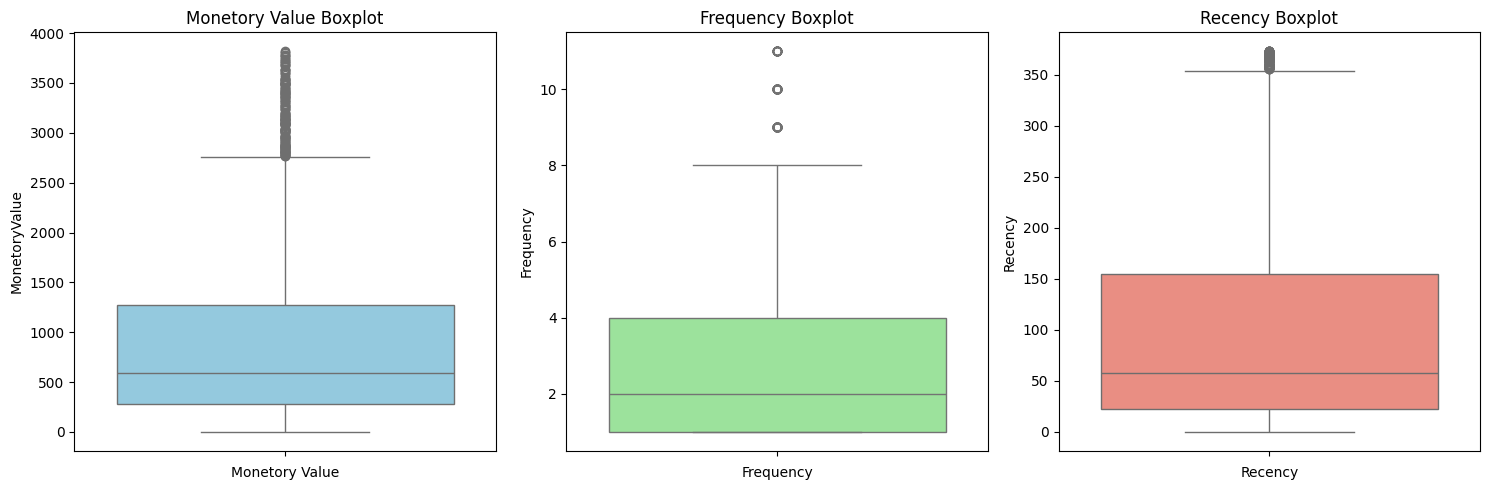

In [30]:
# Outliers detection using boxplots

plt.figure(figsize=(15,5))

# Monetory Value
plt.subplot(1, 3, 1)
sns.boxplot(data=non_outliers_df["MonetoryValue"],color="skyblue")
plt.title("Monetory Value Boxplot")
plt.xlabel("Monetory Value")

# Frequency
plt.subplot(1, 3, 2)
sns.boxplot(data=non_outliers_df['Frequency'], color='lightgreen')
plt.title('Frequency Boxplot')
plt.xlabel('Frequency')

# Recency
plt.subplot(1, 3, 3)
sns.boxplot(data=non_outliers_df['Recency'], color='salmon')
plt.title('Recency Boxplot')
plt.xlabel('Recency')

plt.tight_layout()
plt.show()


### **Data visualization** : 3D scatter plot

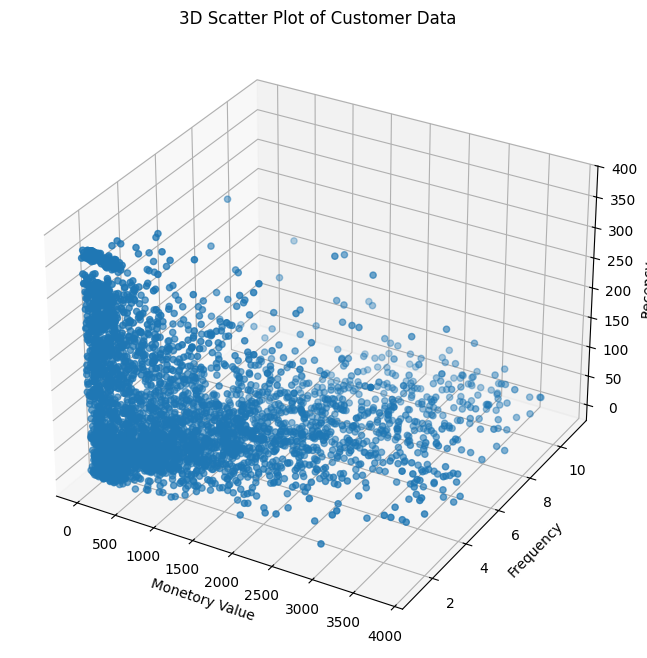

In [34]:
fig = plt.figure(figsize = (8, 8))

ax = fig.add_subplot(projection = "3d")

scatter = ax.scatter(non_outliers_df["MonetoryValue"],non_outliers_df["Frequency"],non_outliers_df["Recency"])

ax.set_xlabel("Monetory Value")
ax.set_ylabel("Frequency")
ax.set_zlabel("Recency")

ax.set_title("3D Scatter Plot of Customer Data")

plt.show()

### **Scaling :**
Our features are on different scales, this causes the data points to be shifted to a corner. 

In fact, the 'monetory value' seems to be emphasized in that 3D plot which means it'll biase our clusters positionning.  

***Standard scaling*** transforms the features of your data to have a mean of 0 and a standard deviation of 1, ensuring that each feature contributes equally to the analysis.

***Formula for Standard Scaling***

Each value x in the dataset is transformed using the formula:

**x_scaled  =  (x−μ)/σ**

Where:

- μ = mean of the feature
- σ = standard deviation of the feature

**Note** :  This assumes the data has a normal distribution.

In [37]:
scaler = StandardScaler()

scaled_data = scaler.fit_transform(non_outliers_df[["MonetoryValue", "Frequency", "Recency"]])
scaled_data

array([[-0.62689958,  3.62975807,  0.66943051],
       [ 0.52559219, -0.38566835, -0.9714245 ],
       [-0.80963268, -0.83182684, -0.25228434],
       ...,
       [-0.56125147, -0.83182684,  1.99629474],
       [ 0.49298639, -0.38566835,  0.13260757],
       [ 1.76530355,  0.50664863, -0.81949348]], shape=(3828, 3))

In [41]:
scaled_data_df = pd.DataFrame(scaled_data, index=non_outliers_df.index,columns=("MonetoryValue","Frequency","Recency"))
scaled_data_df

,MonetoryValue,Frequency,Recency
0,-0.63,3.63,0.67
1,0.53,-0.39,-0.97
2,-0.81,-0.83,-0.25
3,2.16,0.06,-0.57
4,-0.71,-0.83,-0.89
...,...,...,...
4307,-0.30,1.40,-0.82
4308,-0.52,-0.83,-0.32
4309,-0.56,-0.83,2.00
4310,0.49,-0.39,0.13


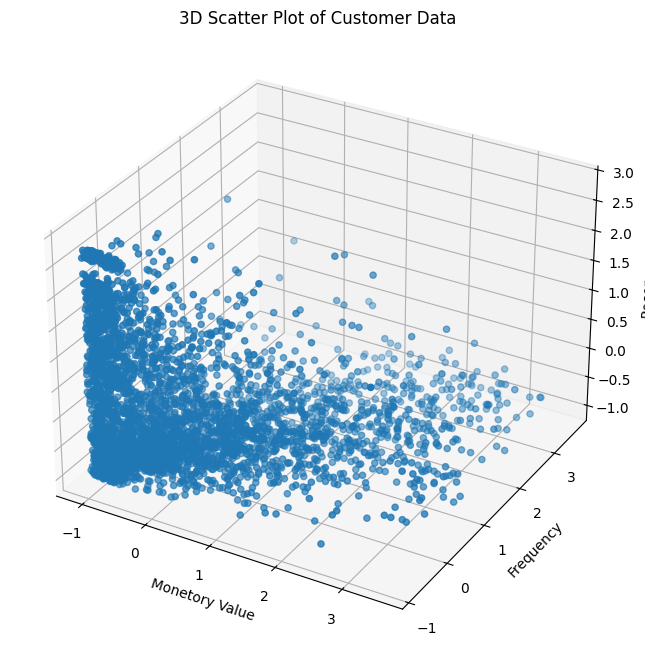

In [42]:
# Replotting the 3D plot after scalling the data
fig = plt.figure(figsize = (8, 8))

ax = fig.add_subplot(projection = "3d")

scatter = ax.scatter(scaled_data_df["MonetoryValue"],scaled_data_df["Frequency"],scaled_data_df["Recency"])

ax.set_xlabel("Monetory Value")
ax.set_ylabel("Frequency")
ax.set_zlabel("Recency")

ax.set_title("3D Scatter Plot of Customer Data")

plt.show()

## K-means clustering

k is a free parameter that represents the number of clusters used (the appropriate number of centroids).

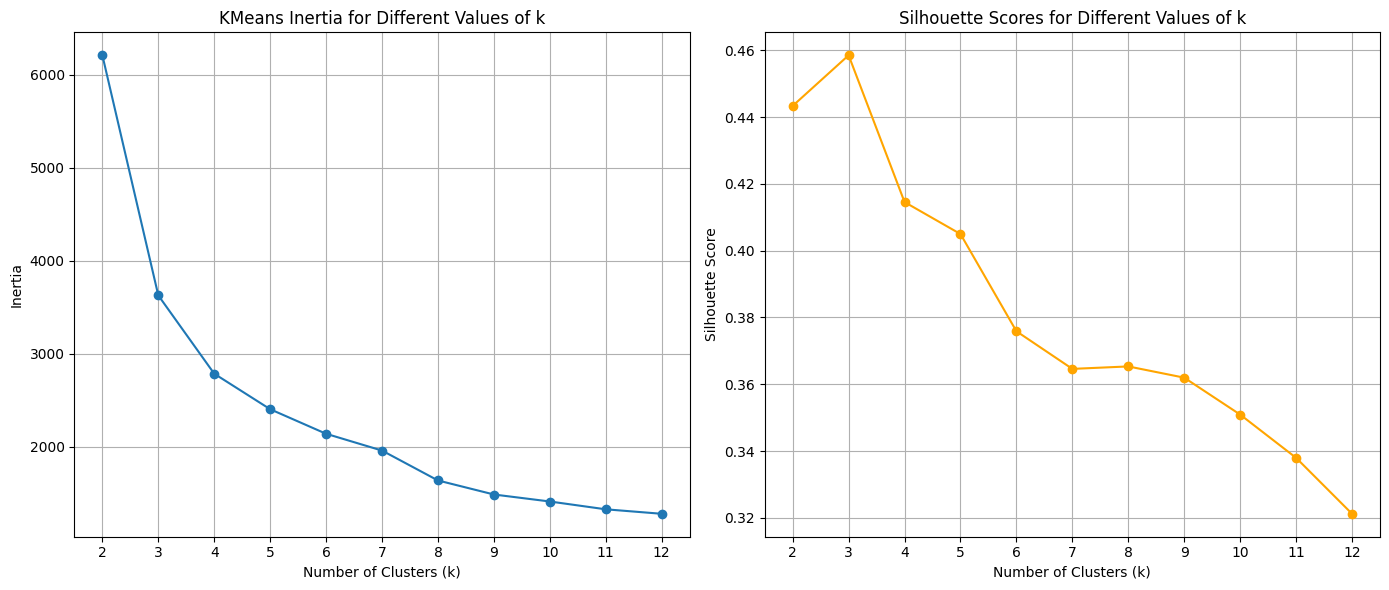

In [52]:
max_k = 12

inertia = []
silhoutte_scores = []
k_values = range(2, max_k + 1)

for k in k_values:

    kmeans = KMeans(n_clusters=k, random_state=42, max_iter=1000)

    cluster_labels = kmeans.fit_predict(scaled_data_df)

    sil_score = silhouette_score(scaled_data_df, cluster_labels)

    silhoutte_scores.append(sil_score)

    inertia.append(kmeans.inertia_)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, marker='o')
plt.title('KMeans Inertia for Different Values of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_values, silhoutte_scores, marker='o', color='orange')
plt.title('Silhouette Scores for Different Values of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)

plt.tight_layout()
plt.show()

Since 4 has a slightly higher silhouette score than 5, the chosen value for k is 4. 

To choose the best k-value to perform clusering, we use another metric called: the ***Silhouette Score***.

**What is the Silhouette Score?**

The Silhouette Score measures the quality of a clustering model by evaluating how well-separated the clusters are. It considers both:

- **Intra-cluster cohesion** (how close points in the same cluster are).
- **Inter-cluster separation** (how far points are from other clusters).

The Silhouette Score ranges from -1 to 1:

- +1 → Well-defined clusters (good clustering).
- 0 → Overlapping clusters (borderline case).
- -1 → Poor clustering (misclassified points).

### Silhouette Score Formula

The **Silhouette Score** for a data point \( i \) is calculated as:




where:
- \( a(i) \) = **Mean intra-cluster distance** (average distance between \( i \) and all other points in the same cluster).
- \( b(i) \) = **Mean nearest-cluster distance** (average distance between \( i \) and points in the nearest neighboring cluster).

The overall **Silhouette Score** for the dataset is the **mean** of all individual scores:


S = \frac{1}{n} \sum_{i=1}^{n} s(i)


where \( n \) is the total number of data points.

In [53]:
kmeans =KMeans(n_clusters=4, random_state=42, max_iter=100)

cluster_labels = kmeans.fit_predict(scaled_data_df)
cluster_labels

array([3, 2, 1, ..., 0, 2, 2], shape=(3828,), dtype=int32)

In [54]:
non_outliers_df["Cluster"] = cluster_labels
non_outliers_df

C:\Users\hp04\AppData\Local\Temp\ipykernel_348\1071184375.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_outliers_df["Cluster"] = cluster_labels


,Customer ID,MonetoryValue,Frequency,LastInvoiceDate,Recency,Cluster
0,12346.00,372.86,11,2010-06-28 13:53:00,164,3
1,12347.00,1323.32,2,2010-12-07 14:57:00,2,2
2,12348.00,222.16,1,2010-09-27 14:59:00,73,1
3,12349.00,2671.14,3,2010-10-28 08:23:00,42,2
4,12351.00,300.93,1,2010-11-29 15:23:00,10,1
...,...,...,...,...,...,...
4307,18283.00,641.77,6,2010-11-22 15:30:00,17,2
4308,18284.00,461.68,1,2010-10-04 11:33:00,66,1
4309,18285.00,427.00,1,2010-02-17 10:24:00,295,0
4310,18286.00,1296.43,2,2010-08-20 11:57:00,111,2


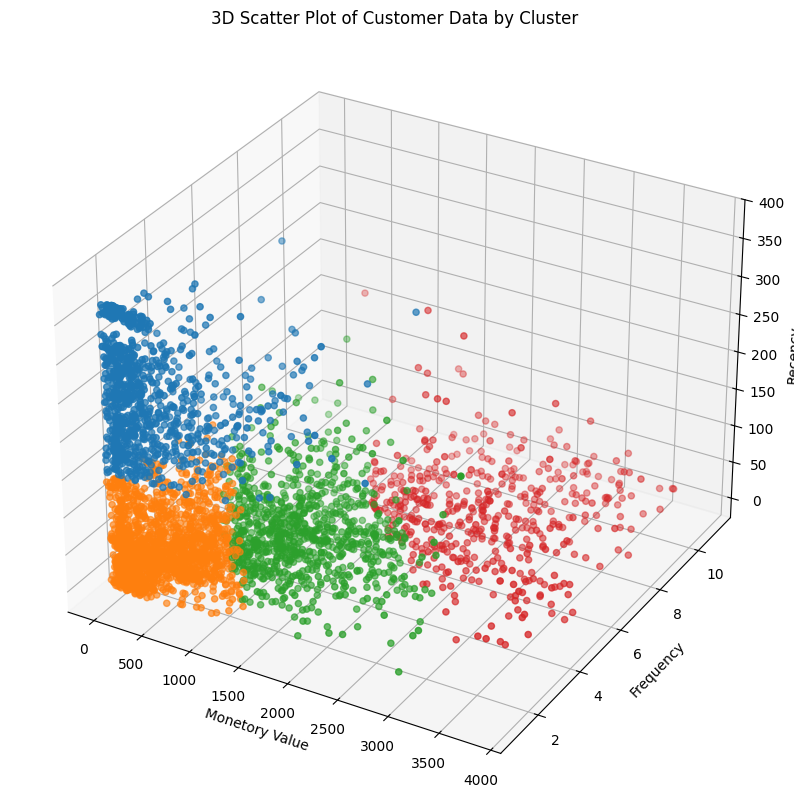

In [56]:
# Clusters Visualization
cluster_colors = {0: '#1f77b4',  # Blue
                  1: '#ff7f0e',  # Orange
                  2: '#2ca02c',  # Green
                  3: '#d62728'}  # Red

colors = non_outliers_df['Cluster'].map(cluster_colors)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

scatter = ax.scatter(non_outliers_df['MonetoryValue'], 
                     non_outliers_df['Frequency'], 
                     non_outliers_df['Recency'], 
                     c=colors,  # Use mapped solid colors
                     marker='o')

ax.set_xlabel('Monetory Value')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

ax.set_title('3D Scatter Plot of Customer Data by Cluster')

plt.show()

### **Violin plot per feature :**

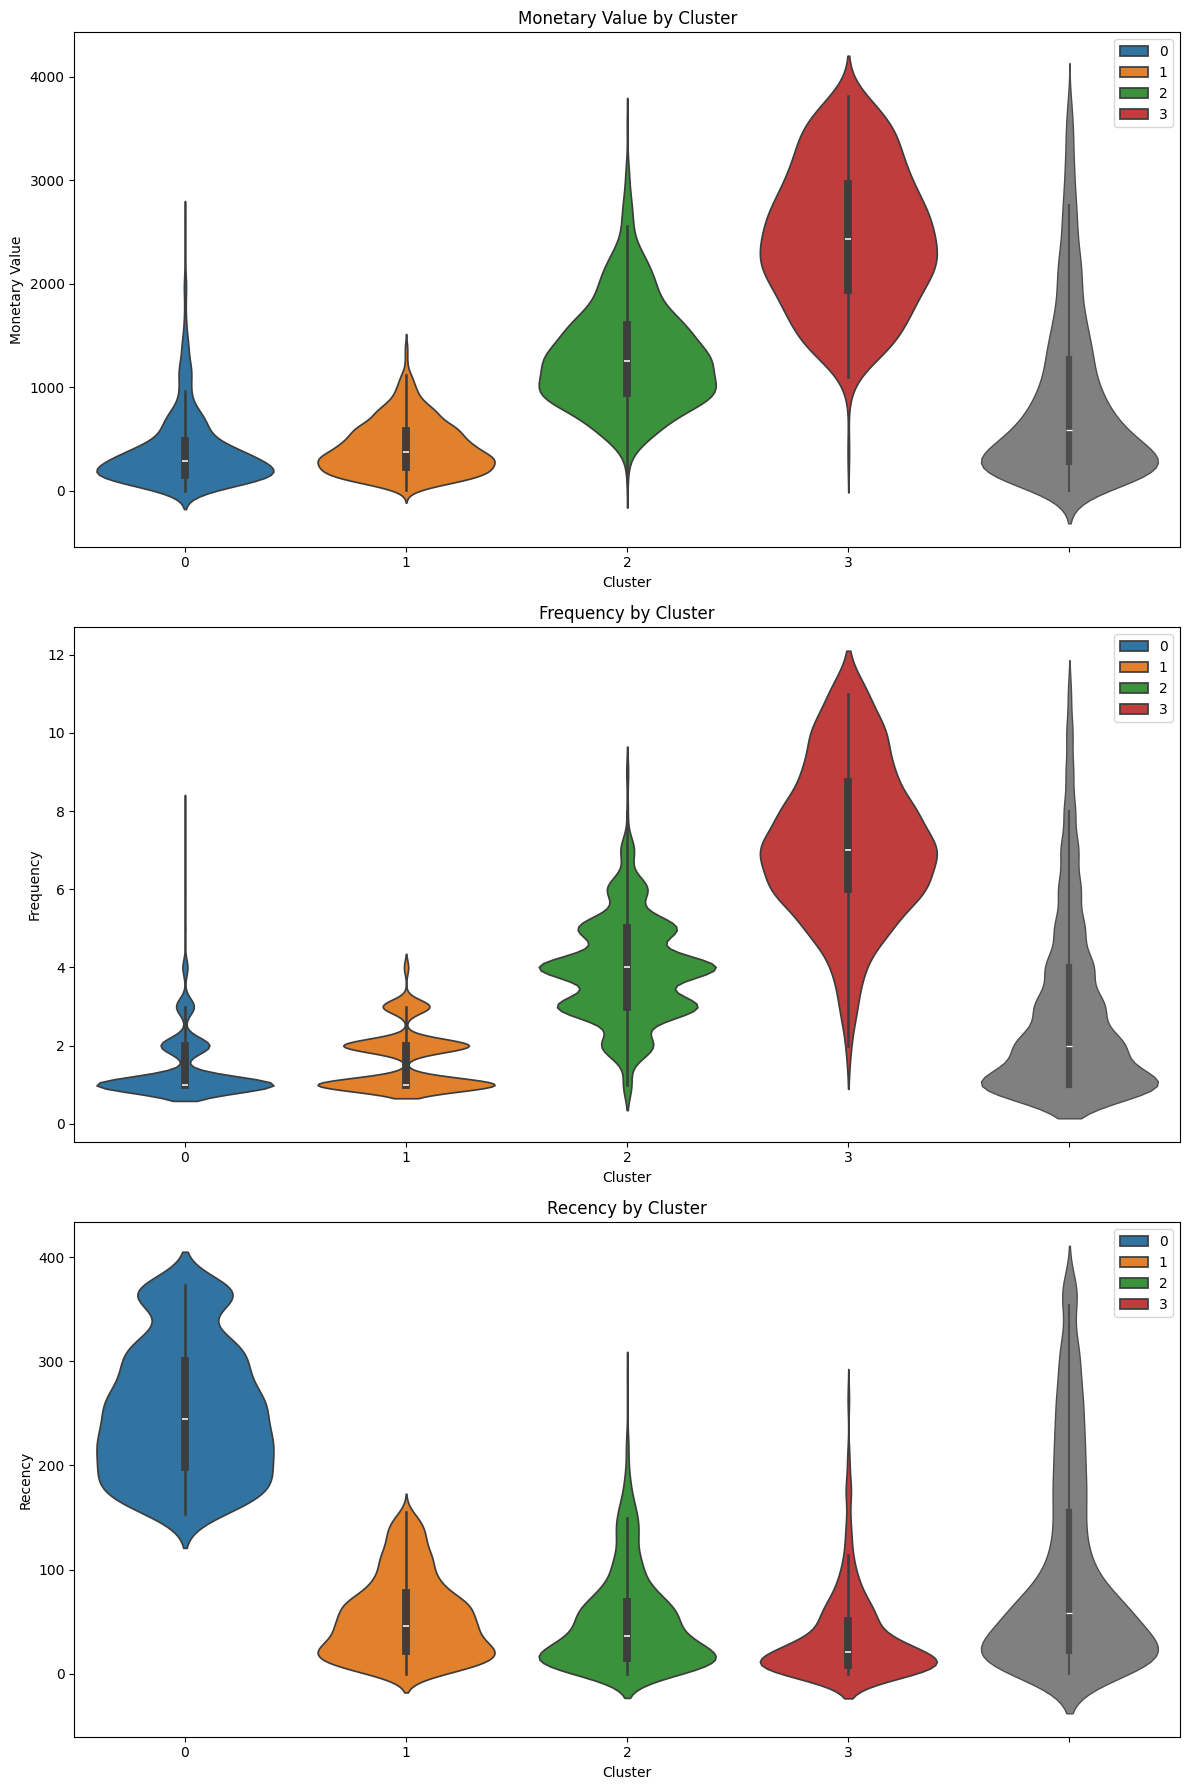

In [58]:
plt.figure(figsize=(12, 18))

plt.subplot(3, 1, 1)
sns.violinplot(x=non_outliers_df['Cluster'], y=non_outliers_df['MonetoryValue'], palette=cluster_colors, hue=non_outliers_df["Cluster"])
sns.violinplot(y=non_outliers_df['MonetoryValue'], color='gray', linewidth=1.0)
plt.title('Monetary Value by Cluster')
plt.ylabel('Monetary Value')

plt.subplot(3, 1, 2)
sns.violinplot(x=non_outliers_df['Cluster'], y=non_outliers_df['Frequency'], palette=cluster_colors, hue=non_outliers_df["Cluster"])
sns.violinplot(y=non_outliers_df['Frequency'], color='gray', linewidth=1.0)
plt.title('Frequency by Cluster')
plt.ylabel('Frequency')


plt.subplot(3, 1, 3)
sns.violinplot(x=non_outliers_df['Cluster'], y=non_outliers_df['Recency'], palette=cluster_colors, hue=non_outliers_df["Cluster"])
sns.violinplot(y=non_outliers_df['Recency'], color='gray', linewidth=1.0)
plt.title('Recency by Cluster')
plt.ylabel('Recency')

plt.tight_layout()
plt.show()

## Interpretation of each cluster's meaning


***Blue: "Re-Engage"***
- Rationale: This cluster represents high-value customers who purchase regularly, though not always very recently. The focus should be on retention efforts to maintain their loyalty and spending levels.
- Action: Implement loyalty programs, personalized offers, and regular engagement to ensure they remain active.

***Green: "Retain"***
- Rationale: This group includes lower-value, infrequent buyers who haven’t purchased recently. The focus should be on re-engagement to bring them back into active purchasing behavior.
- Action: Use targeted marketing campaigns, special discounts, or reminders to encourage them to return and purchase again.

***Orange: "Nurture"***
- Rationale: This cluster represents the least active and lowest-value customers, but they have made recent purchases. These customers may be new or need nurturing to increase their engagement and spending.
- Action: Focus on building relationships, providing excellent customer service, and offering incentives to encourage more frequent purchases.

***Red: "Reward"***
- Rationale: This cluster includes high-value, very frequent buyers, many of whom are still actively purchasing. They are your most loyal customers, and rewarding their loyalty is key to maintaining their engagement.
- Action: Implement a robust loyalty program, provide exclusive offers, and recognize their loyalty to keep them engaged and satisfied.


**Summary of cluster Names :**
- Cluster 0 (Blue) : Re-engage
- Cluster 1 (Orange) : Nurture
- Cluster 2 (Green) : Retain
- Cluster 3 (Red) : Reward

In [59]:
# Dealing with overlap
overlap_indices = monetory_outliers_df.index.intersection(Frequency_outliers_df.index)

monetory_only_outliers = monetory_outliers_df.drop(overlap_indices)
frequency_only_outliers = Frequency_outliers_df.drop(overlap_indices)

monetory_and_frequency_outliers = monetory_outliers_df.loc[overlap_indices]

monetory_only_outliers["Cluster"] = -1
frequency_only_outliers["Cluster"] = -2
monetory_and_frequency_outliers["Cluster"] = -3

outlier_clusters_df = pd.concat([monetory_only_outliers, frequency_only_outliers, monetory_and_frequency_outliers])

outlier_clusters_df

,Customer ID,MonetoryValue,Frequency,LastInvoiceDate,Recency,Cluster
9,12357.00,12079.99,2,2010-11-16 14:29:00,23,-1
26,12380.00,6951.49,7,2010-08-31 14:54:00,100,-1
44,12409.00,12346.62,4,2010-10-15 10:24:00,55,-1
50,12415.00,19543.84,7,2010-11-29 15:07:00,10,-1
64,12433.00,7205.39,5,2010-12-08 16:49:00,1,-1
...,...,...,...,...,...,...
4262,18223.00,7516.31,12,2010-11-17 12:20:00,22,-3
4263,18225.00,7545.14,15,2010-12-09 15:46:00,0,-3
4264,18226.00,6650.83,15,2010-11-26 15:51:00,13,-3
4268,18231.00,4797.70,23,2010-10-29 14:17:00,41,-3


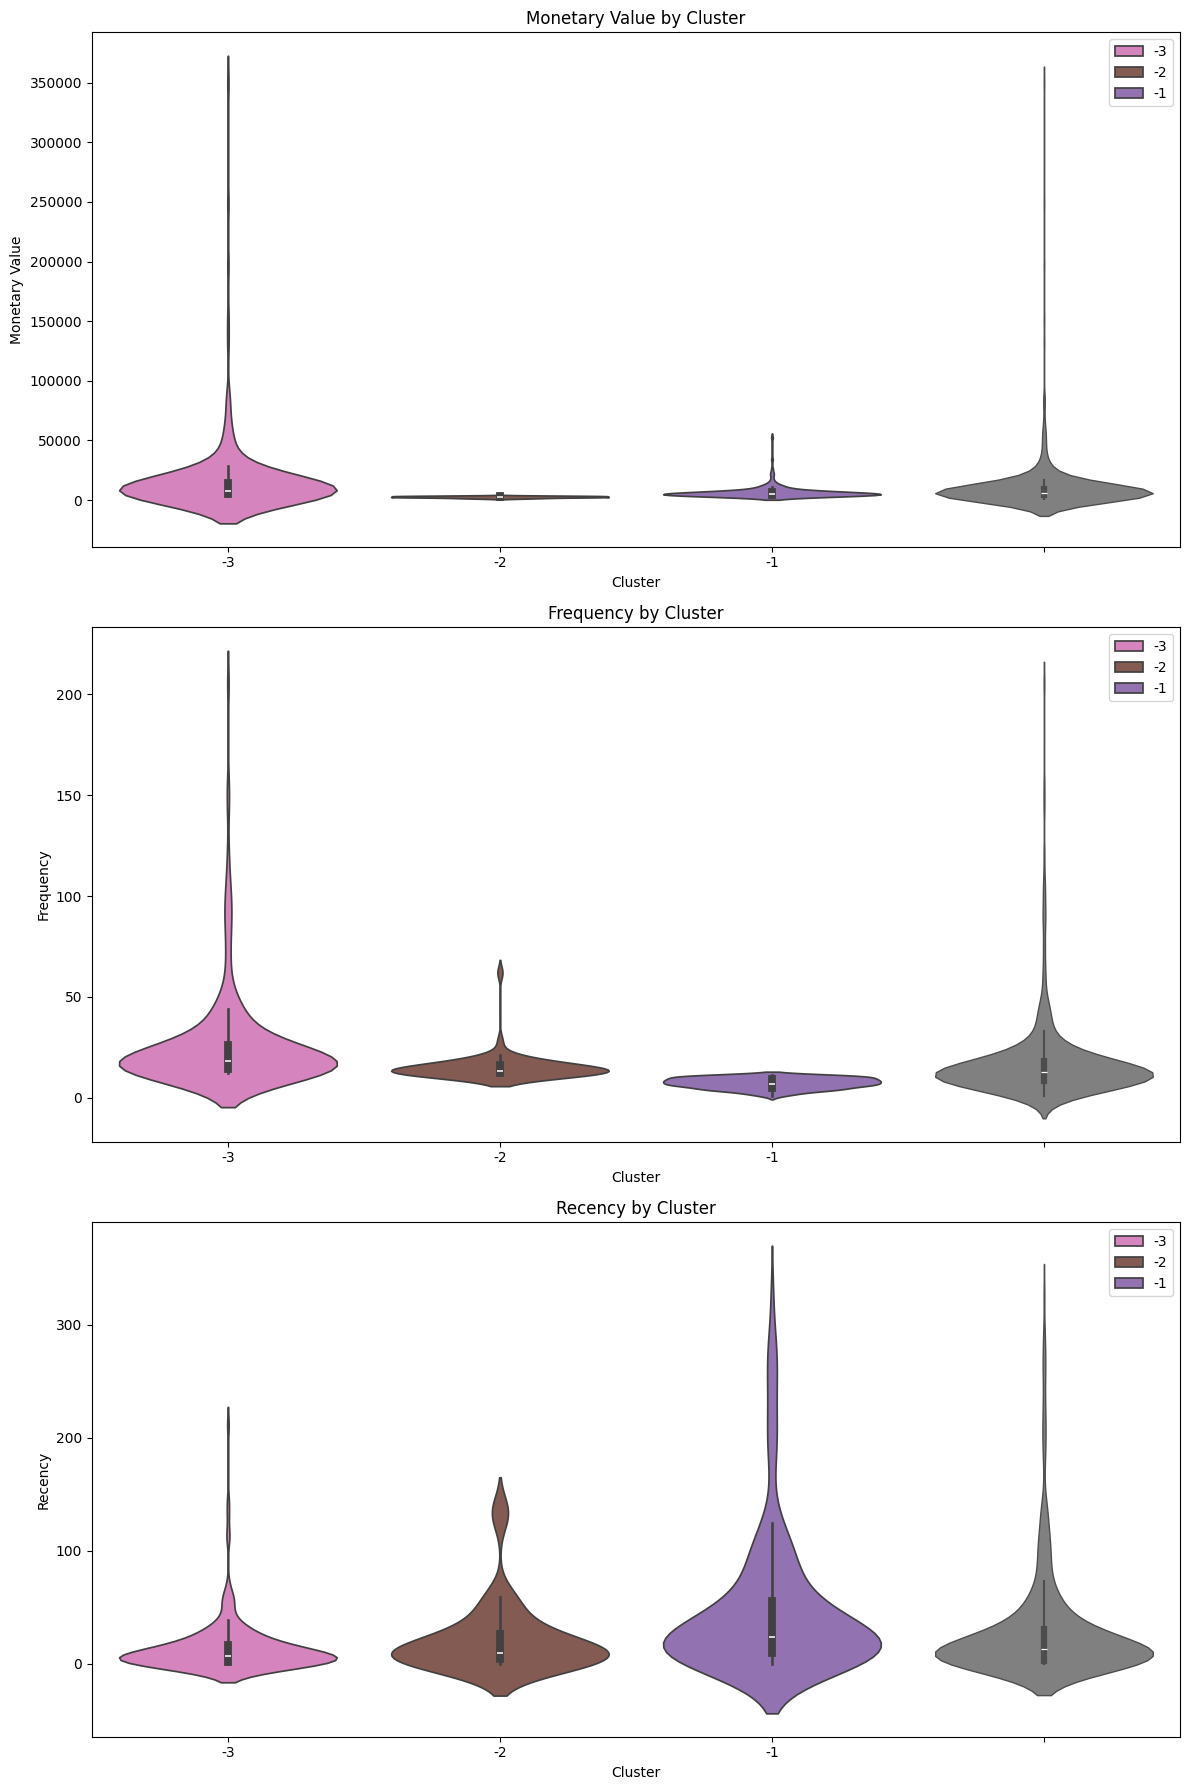

In [60]:
cluster_colors = {-1: '#9467bd',
                  -2: '#8c564b',
                  -3: '#e377c2'}

plt.figure(figsize=(12, 18))

plt.subplot(3, 1, 1)
sns.violinplot(x=outlier_clusters_df['Cluster'], y=outlier_clusters_df['MonetoryValue'], palette=cluster_colors, hue=outlier_clusters_df["Cluster"])
sns.violinplot(y=outlier_clusters_df['MonetoryValue'], color='gray', linewidth=1.0)
plt.title('Monetary Value by Cluster')
plt.ylabel('Monetary Value')

plt.subplot(3, 1, 2)
sns.violinplot(x=outlier_clusters_df['Cluster'], y=outlier_clusters_df['Frequency'], palette=cluster_colors, hue=outlier_clusters_df["Cluster"])
sns.violinplot(y=outlier_clusters_df['Frequency'], color='gray', linewidth=1.0)
plt.title('Frequency by Cluster')
plt.ylabel('Frequency')

plt.subplot(3, 1, 3)
sns.violinplot(x=outlier_clusters_df['Cluster'], y=outlier_clusters_df['Recency'], palette=cluster_colors, hue=outlier_clusters_df["Cluster"])
sns.violinplot(y=outlier_clusters_df['Recency'], color='gray', linewidth=1.0)
plt.title('Recency by Cluster')
plt.ylabel('Recency')

plt.tight_layout()
plt.show()

**Meaningful names for these ouliers clusters**



**Cluster -1 (Monetary Outliers)**

***PAMPER:*** 
- Characteristics: High spenders but not necessarily frequent buyers. Their purchases are large but infrequent. 
- Potential Strategy: Focus on maintaining their loyalty with personalized offers or luxury services that cater to their high spending capacity.

**Cluster -2 (Frequency Outliers)**

***UPSELL:*** 
Characteristics: Frequent buyers who spend less per purchase. These customers are consistently engaged but might benefit from upselling opportunities. Potential Strategy: Implement loyalty programs or bundle deals to encourage higher spending per visit, given their frequent engagement.

**Cluster -3 (Monetary & Frequency Outliers)**

***DELIGHT:*** 
- Characteristics: The most valuable outliers, with extreme spending and frequent purchases. They are likely your top-tier customers who require special attention. 
- Potential Strategy: Develop VIP programs or exclusive offers to maintain their loyalty and encourage continued engagement.



In [61]:
cluster_labels = {
    0: "RE-ENGAGE",
    1: "NURTURE",
    2: "RETAIN",
    3: "REWARD",
    -1: "PAMPER",
    -2: "UPSELL",
    -3: "DELIGHT"
}

In [62]:
full_clustering_df = pd.concat([non_outliers_df, outlier_clusters_df])

full_clustering_df

,Customer ID,MonetoryValue,Frequency,LastInvoiceDate,Recency,Cluster
0,12346.00,372.86,11,2010-06-28 13:53:00,164,3
1,12347.00,1323.32,2,2010-12-07 14:57:00,2,2
2,12348.00,222.16,1,2010-09-27 14:59:00,73,1
3,12349.00,2671.14,3,2010-10-28 08:23:00,42,2
4,12351.00,300.93,1,2010-11-29 15:23:00,10,1
...,...,...,...,...,...,...
4262,18223.00,7516.31,12,2010-11-17 12:20:00,22,-3
4263,18225.00,7545.14,15,2010-12-09 15:46:00,0,-3
4264,18226.00,6650.83,15,2010-11-26 15:51:00,13,-3
4268,18231.00,4797.70,23,2010-10-29 14:17:00,41,-3


In [63]:
full_clustering_df["ClusterLabel"] = full_clustering_df["Cluster"].map(cluster_labels)

full_clustering_df

,Customer ID,MonetoryValue,Frequency,LastInvoiceDate,Recency,Cluster,ClusterLabel
0,12346.00,372.86,11,2010-06-28 13:53:00,164,3,REWARD
1,12347.00,1323.32,2,2010-12-07 14:57:00,2,2,RETAIN
2,12348.00,222.16,1,2010-09-27 14:59:00,73,1,NURTURE
3,12349.00,2671.14,3,2010-10-28 08:23:00,42,2,RETAIN
4,12351.00,300.93,1,2010-11-29 15:23:00,10,1,NURTURE
...,...,...,...,...,...,...,...
4262,18223.00,7516.31,12,2010-11-17 12:20:00,22,-3,DELIGHT
4263,18225.00,7545.14,15,2010-12-09 15:46:00,0,-3,DELIGHT
4264,18226.00,6650.83,15,2010-11-26 15:51:00,13,-3,DELIGHT
4268,18231.00,4797.70,23,2010-10-29 14:17:00,41,-3,DELIGHT


## Final Visualisation

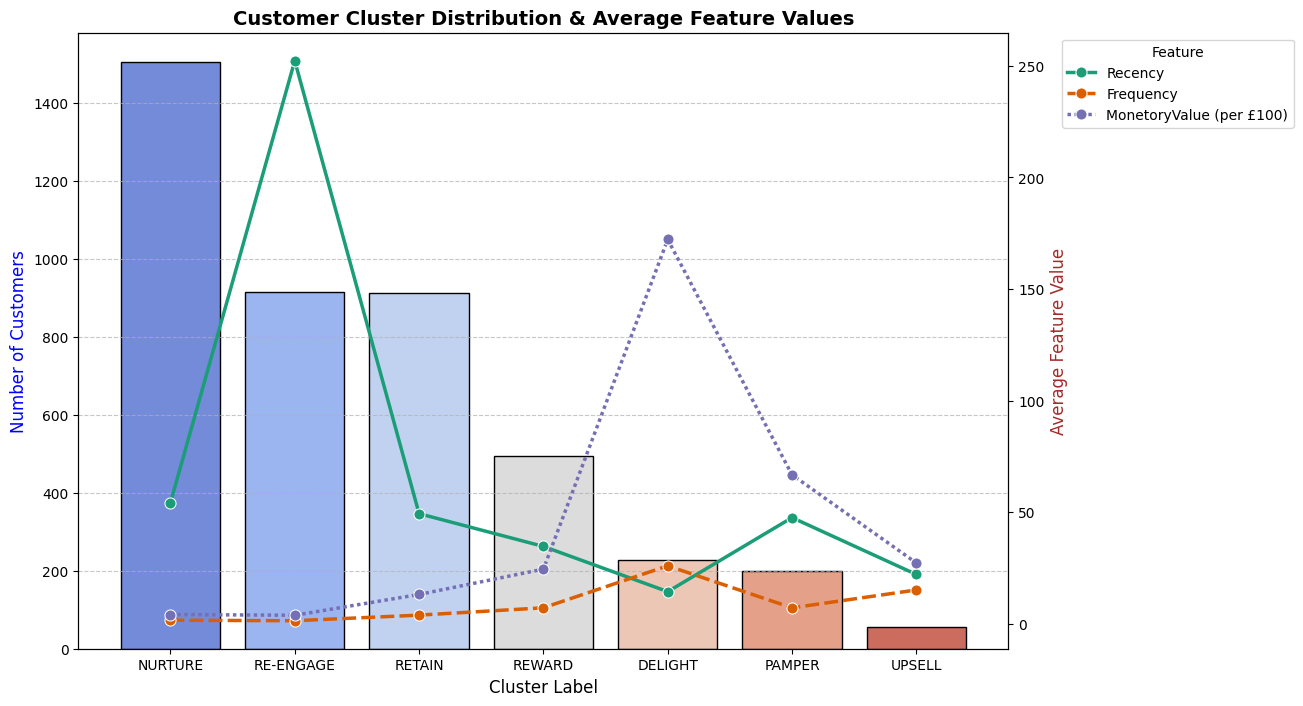

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute cluster distribution
cluster_counts = full_clustering_df['ClusterLabel'].value_counts()

# Normalize MonetaryValue for better readability
full_clustering_df["MonetoryValue (per £100)"] = full_clustering_df["MonetoryValue"] / 100.00

# Compute feature means for each cluster
feature_means = full_clustering_df.groupby('ClusterLabel')[['Recency', 'Frequency', 'MonetoryValue (per £100)']].mean()

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(12, 8))

# Barplot for cluster distribution with new color palette
sns.barplot(
    x=cluster_counts.index, y=cluster_counts.values, 
    ax=ax1, palette='coolwarm', hue=cluster_counts.index, 
    edgecolor='black'
)
ax1.set_xlabel('Cluster Label', fontsize=12)
ax1.set_ylabel('Number of Customers', fontsize=12, color='b')
ax1.set_title('Customer Cluster Distribution & Average Feature Values', fontsize=14, fontweight='bold')

# Add grid for better readability
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Create second y-axis for feature means
ax2 = ax1.twinx()

# Line plot for average feature values per cluster with new color palette
sns.lineplot(data=feature_means, ax=ax2, palette='Dark2', marker='o', linewidth=2.5, markersize=8)

# Improve axis labels
ax2.set_ylabel('Average Feature Value', fontsize=12, color='brown')

ax2.legend(title="Feature", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.show()

